# Esercizio 4 - Segmentation

**Commenti:**  
Avevo iniziato con il *cosine similarity approach*, ma non sono purtroppo riuscito a farlo funzionare in modo soddisfacente per trovare i tagli.  
Ho quindi deciso di provare con un approccio molto più banale, ma che ha dato risultati enormemente migliori.  
Per entrambi gli approcci ho usato la libreria *nltk* per la tokenizzazione, la lemmatizzazione e la rimozione delle stopwords del testo.

## File di input

Come file di input uso un file di testo contenente un po' di paragrafi presi da Wikipedia riguardo a 4 argomenti diversi:
- Lebanon
- Racing bike
- Labrador retriever
- Indie rock  

I tagli che dovrebbe trovare il mio algoritmo sono alla linea 27-28, alla linea 58-59 e alla linea 97-98.


In [111]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from collections import Counter

### Preprocessing del file di input

In [112]:
data = []
with open('../data/wiki.txt', 'r') as f:
    for line in f:
        data.append(line.strip())
    
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')

preprocessed_data = []
for line in data:
    words = [lemmatizer.lemmatize(token.lower()) for token in tokenizer.tokenize(line) if token.lower() not in stop_words] 
    preprocessed_data.append(words)

# Random approach

## Idea:

- Scelgo randomicamente dei tagli (occorre sapere il numero di tagli)
- Taglio il documento di input preprocessato in base ai tagli scelti
- Seleziono le parole presenti nei segmenti ritagliati
- Calcolo la similarity del segment: è data dalla somma della frequenza delle *n* parole più comuni all'interno del segment, più è alta più il segment è consistente.
- Calcolo la somma delle similarity dei segments per sapere la correttezza dei tagli scelti.
- Ripeto il processo n volte e scelgo i tagli che danno la somma più alta.


In [113]:
# Get the segments given a start and end point
def get_segments(document, start, end):
    segment = []
    for i in range(start, end):
        segment.append(document[i])
    return segment

# Get words given a segment
def get_words(segment):
    words = []
    for line in segment:
        for word in line:
            words.append(word)
    return words

# Get similarity of a segment as the sum of n most common words counts in the segment
def get_count_sim(segment, n):
    words = []
    for word in segment:
        words.append(word)
    count_freq_words = Counter(words)
    score = 0
    for word, count in count_freq_words.most_common(n):
        score += count
    return score, count_freq_words.most_common(n)

# Get random cut points given the number of lines in the document and the number of segments
def get_random_cut_points(n_lines, n_segments):
    cut_points = [0,0,0,0]
    for i in range(1, n_segments): # 1 has to be 0
        cut_points[i] = np.random.randint(1, n_lines - 1) # In between line 1 and (last line - 1)
    cut_points.append(n_lines)
    return sorted(cut_points)

# Run for n iterations and return the best cut points
def get_best_cut_points(n_iterations, n_segments, n_lines, n_words, document):
    segment_scores = [0,0,0,0]
    total_segment_score = 0
    best_score = 0
    best_cut_points = []
    for i in range(n_iterations):
        cut_points = get_random_cut_points(n_lines, n_segments)
        for i in range(len(cut_points) - 1):
            segment = get_segments(document, cut_points[i], cut_points[i+1])
            words = get_words(segment)
            segment_scores[i] = get_count_sim(words, n_words)[0]
        total_segment_score = sum(segment_scores)
        if total_segment_score > best_score:
            best_score = total_segment_score
            best_cut_points = cut_points
    return best_cut_points, best_score

### Risultati del random approach

In [114]:
# Try with different number of frequent words and iterations
# The number of segments is fixed to 4, since the input document is always the same
n_iterations = 10000
n_lines = len(preprocessed_data)
n_freq_words = 15
n_segments = 4
cut_points, best_score = get_best_cut_points(n_iterations, n_segments, n_lines, n_freq_words, preprocessed_data)
for i in range(1, len(cut_points) - 1):
    print(f'Cut point {i}: {cut_points[i]}')
print(f'Best score: {best_score}')

Cut point 1: 27
Cut point 2: 58
Cut point 3: 95
Best score: 992


### Salvataggio dell'output

In [115]:
# Split the original document in segments
random_segments = []
random_cuts = cut_points
for i in range(len(random_cuts) - 1):
    random_segments.append(get_segments(data, random_cuts[i], random_cuts[i+1]))

# Save the results in a file
with open('../output/random-segments.txt', 'w') as f:
    for segment in random_segments:
        f.write('\n\nSEGMENT\n')
        for line in segment:
            f.write(line + '\n')

# Cosine similarity approach

## Idea:

- Creo lista di tutte le parole presenti nel file di input preprocessato
- Per ogni paragrafo del file di input preprocessato, creo un vettore di lunghezza pari al numero di parole presenti nel file di input preprocessato (senza ripetizioni), in cui ogni elemento è la frequenza della parola corrispondente
- Ogni paragraph considerato avrà dimensione n, ovvero gruppi di n parole consecutive del file di input preprocessato
- Calcolo la cosine similarity tra ogni paragrafo e il paragrafo successivo. Utilizzo la funzione *cosine_similarity* della libreria *sklearn*
- Posiziono i tagli negli n punti di minimo locale della cosine similarity più bassi, dove n è il numero degli argomenti che voglio individuare nel file di input - 1. Utilizzo la funzione *find_peaks* della libreria *scipy.signal* per trovare i punti di minimo locale


### Creo una lista di tutte le relevant words del file di input in ordine di apparizione

Con ripetizioni, ovvero trasformo in una lista di parole il file di input preprocessato

In [116]:
# Convert preprocessed data to a list
doc = []
for line in preprocessed_data:
    for word in line:
        doc.append(word)

# Remove duplicates but keep the order
unique_words = list(dict.fromkeys(doc))

print(f'Number of words in the document: {len(doc)}')
print(f'Number of unique words in the document: {len(unique_words)}')

Number of words in the document: 5115
Number of unique words in the document: 2160


### Creo un dizionario per ogni paragrafo del file di input, dove la chiave è la parola e il valore la sua frequenza e lo trasformo in lista di frequenze

In [117]:
# Split the document (which is a list) by a given number of words
# Return a list of lists which is gonna be the list of paragraphs
def split_doc(document, n):
    return [document[i:i+n] for i in range(0, len(document), n)]

# Create a dictionary with keys = all words in a document, values = word counts in a paragraph
def paragraph_dict(paragraph, document):
    paragraph_dict = {}
    for word in document:
        paragraph_dict[word] = 0
    for word in paragraph:
        paragraph_dict[word] += 1
    return paragraph_dict

# From the dictionary create a list of word counts
def paragraph_list(paragraph_dict, document):
    paragraph_list = []
    for word in document:
        paragraph_list.append(paragraph_dict[word])
    return paragraph_list

# Get for all paragraphs (splitted by n words) a list of word counts
def get_paragraphs_list(document, n):
    paragraphs = split_doc(document, n)
    paragraphs_list = []
    for paragraph in paragraphs:
        paragraphs_list.append(paragraph_list(paragraph_dict(paragraph, document), document))
    return paragraphs_list

### Calcolo della cosine similarity tra ogni paragraph e il paragraph successivo

In [118]:
# Compute cosine similarity between all paragraphs
def cos_sim(n):
    cos_sim_list = []
    par_list = get_paragraphs_list(doc, n)
    for i in range(0, len(par_list) - 3):
        par1 = par_list[i]
        par2 = par_list[i + 1]
        cos_sim_list.append(cosine_similarity([par1], [par2])[0][0])
        # print(f'Paragraphs {i + 1} and {i + 2} are similar with a cosine similarity of {cos_sim_list[i]}')
    return cos_sim_list, par_list

### Posiziono i tagli nei punti di minimo della cosine similarity

In [119]:
# Search the minimums in the list of cosine similarities
def find_mins(list):
    list = np.array(list)*-1
    mins = find_peaks(list)[0]
    return mins

# Get the indexes of the cut points
def get_cut_indexes(document, n_par_words, n_cuts):
    cos_sim_list, par_list = cos_sim(n_par_words)
    min_indexes = find_mins(cos_sim_list)
    mins = [cos_sim_list[i] for i in min_indexes]
    mins = sorted(mins)[0:n_cuts]
    cut_indexes = [cos_sim_list.index(min) for min in mins]
    cut_indexes = sorted(cut_indexes)
    cut_indexes = [i * n_par_words for i in cut_indexes]
    return cut_indexes

# Find cut points and cut the document
def cut_doc(document, n_par_words, n_cuts):
    cut_indexes = get_cut_indexes(document, n_par_words, n_cuts)
    paragraphs = []
    p1 = document[0:cut_indexes[0]]
    paragraphs.append(p1)
    p2 = document[cut_indexes[0]:cut_indexes[1]]
    paragraphs.append(p2)
    p3 = document[cut_indexes[1]:cut_indexes[2]]
    paragraphs.append(p3)
    p4 = document[cut_indexes[2]:]
    paragraphs.append(p4)
    return paragraphs

# Try with different number of words per paragraph
n = 100
n_cuts = 3
paragraphs = cut_doc(doc, n, n_cuts)

### Plot della cosine similarity

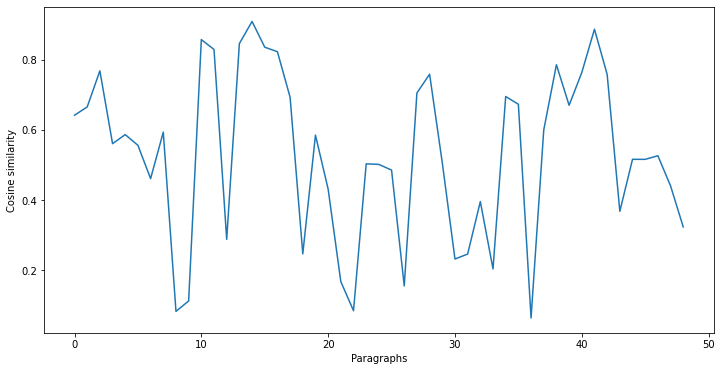

In [120]:
# Plot the cosine similarity
fig = plt.figure(figsize=(12, 6))
plt.plot(cos_sim(n)[0])
plt.xlabel('Paragraphs')
plt.ylabel('Cosine similarity')
plt.show()

### Salvataggio dell'output

Tuttavia questo stamperà il file preprocessed, non il file di input originale.

In [121]:
# Save results to an output file
with open('../output/cosine-segments.txt', 'w') as f:
    f.write(f'Considering {n} words per paragraph and {n_cuts} cuts\n')
    for paragraph in paragraphs:
        f.write('\n\nSEGMENT\n')
        count = 0
        count_N = 0
        for word in paragraph:
            f.write(word + ' ')
            count += 1
            count_N += 1
            if count == 18:
                f.write('\n')
                count = 0
            if count_N == n:
                count_N = 0